# Project Extension #2: Random Forest

### Part I: Creating and Training Both A Standard Decision Tree and Random Forest Classifier Using SciKit Learn

##### We will first use the MNIST digits dataset from SciKit Learn

In [1]:
from sklearn.datasets import load_digits # The MNIST data set is in scikit learn data set
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
import numpy as np
import matplotlib.pyplot as plt 

The shape of the digits dataset:
(1797, 64)


<Figure size 640x480 with 0 Axes>

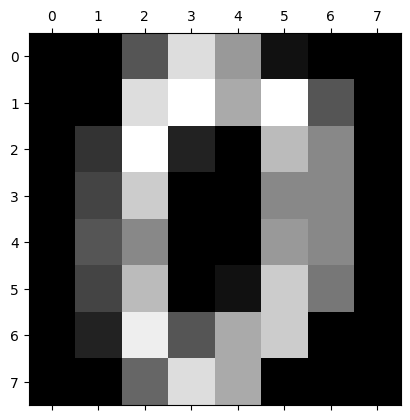

[0]
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


In [2]:
digits=load_digits()
X = digits.data
print("The shape of the digits dataset:") 
print(digits.data.shape)
plt.gray()
plt.matshow(digits.images[0])
plt.show()
y = digits.target
print(y[0:1])
print(X[0,:])

In [37]:
#Split the data into training and test set.  60% training and %40 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
print(y_train.shape)
print(X_train.shape)

(1078,)
(1078, 64)


##### Standard Decision Tree

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
dt.score(X_test,y_test)

0.8289290681502086

##### Random Forest

In [39]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train,y_train)
rf.score(X_test,y_test)

0.96105702364395

### Part II: Creating a Decision Tree From Scratch

In [30]:
# Entropy Function
def entropy(y):
    ysort = np.sort(y)
    total = len(y)
    if total == 0:
        return 0
    count = 1
    entropy = 0
    for i in range(1,len(y)):
        if ysort[i] == ysort[i-1]:
            count += 1
        else:
            if count > 0:
                entropy += -1*(count/total)*np.log2(count/total)
                count = 1
    if count > 0:
        entropy += -1*(count/total)*np.log2(count/total)
    return entropy
    

In [31]:
class TreeNode:
    def __init__(self, f, t):
        self.f = f
        self.t = t
        self.l = None
        self.r = None

class Leaf:
    def __init__(self, X, y, label):
        self.X = X
        self.y = y
        self.label = label


def allEqual(arr):
    if arr is None or len(arr) <= 1:
        return True
    num = arr[0]
    for val in arr:
        if num != val:
            return False
    return True



def createTree(X, y, level, maxlevel):
    if allEqual(y) or level >= maxlevel:
        if y is None:
            return None
        else:
            digits = np.zeros((10,1),dtype=int) 
            for val in y:
                digits[int(val)] += 1
            leaf = Leaf(X, y, np.argmax(digits))
            return leaf
    else:
        bestF, bestT, X1, X2, y1, y2 = findBestSplit(X, y)
        root = TreeNode(bestF, bestT)
        root.l = createTree(X1, y1, level + 1, maxlevel)
        root.r = createTree(X2, y2, level + 1, maxlevel)
        return root

def findBestSplit(X, y):
    bestF = 0
    bestT = 0
    gain = 0
    ylen = len(y)
    X1 = None
    X2 = None
    y1 = None
    y2 = None
    Xy = np.append(X,np.reshape(y, (len(y),1)),axis = 1)
    ycol = len(Xy[0]) - 1
    ent = entropy(y)
    for i in range(len(X[0])): 
        sortX = Xy[Xy[:, i].argsort()]
        for j in range(1, len(X)):
            if sortX[j][ycol] != sortX[j-1][ycol]:
                newgain = ent - ((len(sortX[:j, ycol])/ylen)*entropy(sortX[:j,ycol]) + (len(sortX[j:,ycol])/ylen)*entropy(sortX[j:,ycol]))
                if gain < newgain:
                    gain = newgain
                    bestF = i
                    bestT = sortX[j][i]   
                    X1 = sortX[:j, :ycol]  
                    X2 = sortX[j:, :ycol]
                    y1 = sortX[:j,ycol]
                    y2 = sortX[j:,ycol]
    return bestF, bestT, X1, X2, y1, y2

def treePrint(root):
    if root is not None and type(root) == TreeNode:
        print("Best Feature: ", root.f)
        print("Best Threshold: ", root.t)
        print("\n")
        if root.l is not None:
            treePrint(root.l)
        if root.r is not None:
            treePrint(root.r)
    elif type(root) == Leaf:
        print("Entropy: ", entropy(root.y))
        print("Labels at node:", root.y)
        print("\n")

In [40]:
root = createTree(X_train, y_train, 0, 7)

In [42]:
def predict(node, X):
    root = node
    res = []
    for digit in X:
        while type(node) != Leaf:
            if digit[node.f] < node.t:
                node = node.l
            else:
                node = node.r
        res.append(node.label)
        node = root
    return res

def accuracy(res, y):
    correct = 0
    for i, num in enumerate(res):
        if res[i] == y[i]:
            correct += 1
    print("Accuracy: ", correct/len(y))


accuracy(predict(root, X_test), y_test)


Accuracy:  0.8122392211404729


### Part III: Creating a Random Forest Classifier From Scratch to Improve Accuracy

In [46]:
def rf_trainingSet_features(X, y):
    rand_row = np.random.choice(X.shape[0], len(X), replace=True)
    rand_col = np.random.choice(X.shape[1], int(np.sqrt(X.shape[1])), replace=False)
    X_subset = X[rand_row, :]
    X_subset = X_subset[:, rand_col]
    y_subset = y[rand_row]
    return X_subset, y_subset, rand_col

def randomForest(X, y, m, maxlevel):
    forest = []
    cols = []
    for i in range(m):
        tempX_train, tempy_train, col = rf_trainingSet_features(X, y)
        forest.append(createTree(tempX_train, tempy_train, 0, maxlevel))
        cols.append(col)
        if i % 10 == 0:
            if i == 0:
                print("Tree #: 1")
            else:
                print("Tree #:", i)
    return forest, cols

def forestPredict(forest, cols, X, m):
    res = np.empty((m, X.shape[0]))
    finalres = []
    for i, tree in enumerate(forest):
        res[i] = np.array(predict(tree, X[:,cols[i]]))
    for i in range(len(res[0])):
        vals, counts = np.unique(res[:,i].astype('int'), return_counts=True)
        mode_index = np.argwhere(counts == np.max(counts))[0]
        mode_value = vals[mode_index]  # Get the actual mode value
        ind = np.random.randint(0,len(mode_value))
        finalres.append(mode_value[ind])
    return finalres
    
    

In [44]:
forest, cols = randomForest(X_train, y_train, 100, 7)

Tree #: 1
Tree #: 10
Tree #: 20
Tree #: 30
Tree #: 40
Tree #: 50
Tree #: 60
Tree #: 70
Tree #: 80
Tree #: 90


In [45]:
prediction = forestPredict(forest, cols, X_test, 100)
accuracy(prediction, y_test)

Accuracy:  0.9276773296244785


### Part IV: Testing Our Decision Tree on a New Dataset - kmnist dataset of Japanese (Hiragana) characters

Train images shape: (1400, 784)
Train labels shape: (1400,)


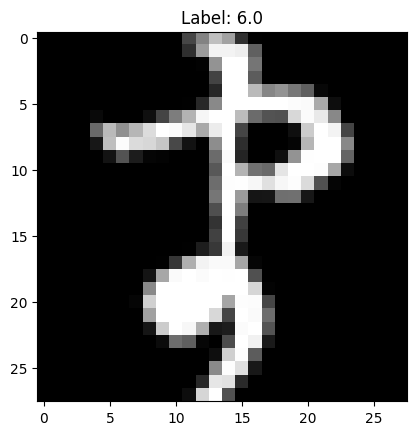

In [62]:
import tensorflow_datasets as tfds

dataset= tfds.load('kmnist', split='train', with_info=False)

X, y = [], []

for example in dataset:
    X.append(example['image'])
    y.append(example['label'])

X = np.array(X)
y = np.array(y).reshape((len(y),1))

X = X / 255.0

X = X.reshape(X.shape[0], -1)

Xy = np.append(X, y, axis = 1)

np.random.shuffle(Xy)

X = Xy[0:1400, 0:len(X[0])]
y = Xy[0:1400, len(X[0])]

print("Train images shape:", X.shape)
print("Train labels shape:", y.shape)

img = X[0].reshape(28, 28)

plt.imshow(img, cmap='gray')
plt.title(f"Label: {y[0]}")
plt.show()

In [63]:
X_scale = StandardScaler()
X = X_scale.fit_transform(X)

X[0,:]

print(X.shape)

(1400, 784)


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [65]:
root = createTree(X_train, y_train, 0, 7)

In [66]:
accuracy(predict(root, X_test), y_test)

Accuracy:  0.4


### Part V: Testing Our Random Forest on The New Dataset

In [67]:
forest, cols = randomForest(X_train, y_train, 100, 7)

Tree #: 1
Tree #: 10
Tree #: 20
Tree #: 30
Tree #: 40
Tree #: 50
Tree #: 60
Tree #: 70
Tree #: 80
Tree #: 90


In [68]:
prediction = forestPredict(forest, cols, X_test, 100)
accuracy(prediction, y_test)

Accuracy:  0.6892857142857143
